<a href="https://colab.research.google.com/github/suryanshu07/Disease-Classification/blob/main/Insaid_Task_85acc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importing the dependencies**

In [44]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

### **Importing the data**

In [45]:
data = pd.read_csv('/content/Fraud.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [46]:
data.shape

(6362620, 11)

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## **Exploratory Data Analysis**

In [48]:
data.isnull().values.any()

False

Text(0, 0.5, 'Frequency')

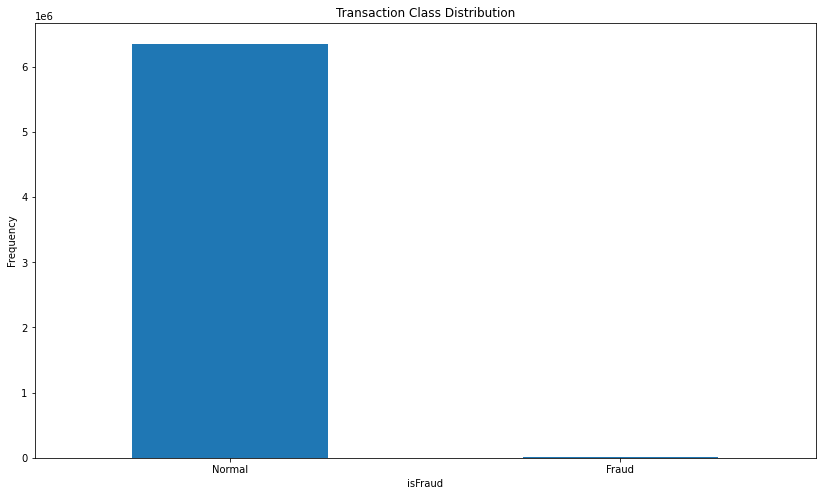

In [49]:
count_classes = pd.value_counts(data['isFraud'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("isFraud")

plt.ylabel("Frequency")

In [50]:
## Get the Fraud and the normal dataset 

fraud = data[data['isFraud']==1]

normal = data[data['isFraud']==0]

In [51]:
print(fraud.shape,normal.shape)

(8213, 11) (6354407, 11)


In [52]:
## We need to analyze more amount of information from the transaction data
#How different are the amount of money used in different transaction classes?
fraud.amount.describe()

count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64

In [53]:
normal.amount.describe()

count    6.354407e+06
mean     1.781970e+05
std      5.962370e+05
min      1.000000e-02
25%      1.336840e+04
50%      7.468472e+04
75%      2.083648e+05
max      9.244552e+07
Name: amount, dtype: float64

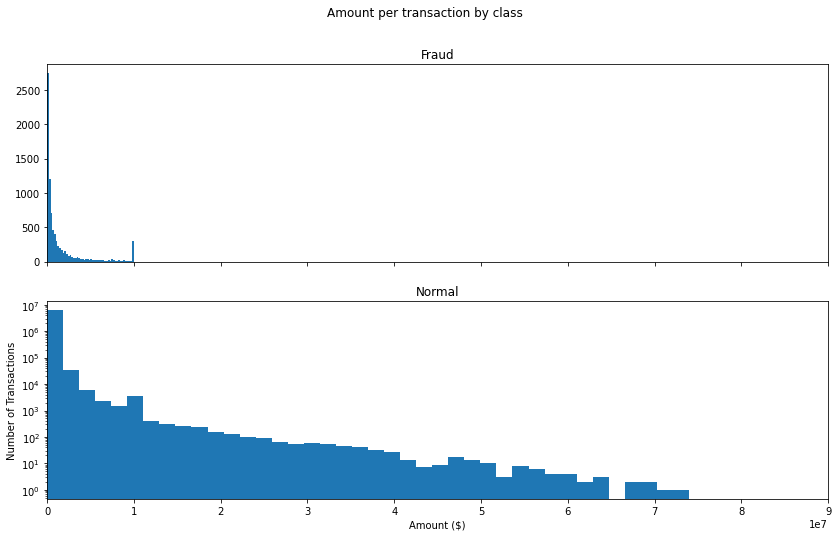

In [54]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 90000000))
plt.yscale('log')
plt.show();

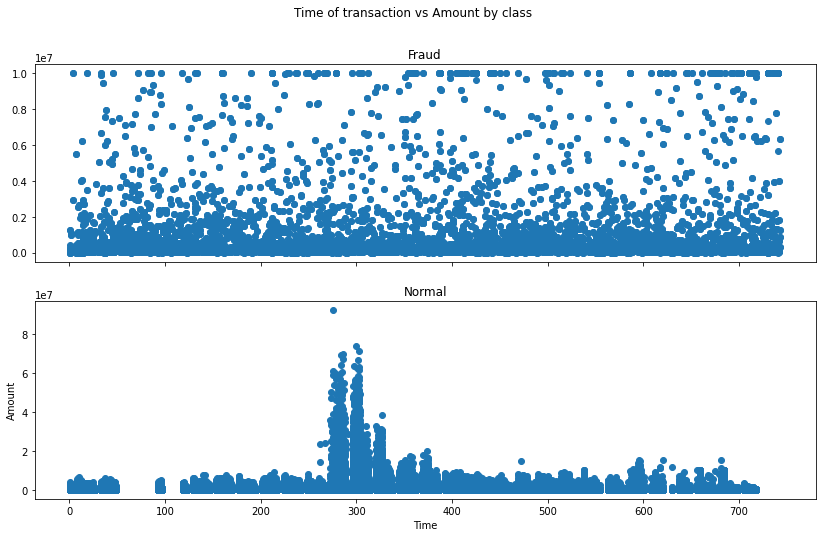

In [55]:
# We Will check Do fraudulent transactions occur more often during certain time frame ? Let us find out with a visual representation.

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(fraud.step, fraud.amount)
ax1.set_title('Fraud')
ax2.scatter(normal.step, normal.amount)
ax2.set_title('Normal')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.show()

In [56]:
X = data.iloc[:,0:10]

In [57]:
X

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1


In [58]:
data['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [59]:
ohe = OneHotEncoder(drop='first',sparse=False)

In [60]:
feature_arry = ohe.fit_transform(X[['type']])

In [61]:
feature_arry.shape

(6362620, 4)

In [62]:
feature_arry

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]])

In [63]:
encoded = pd.DataFrame(feature_arry,columns=['CASH_OUT','DEBIT','PAYMENT','TRANSFER'])

In [64]:
encoded_df = pd.concat([X,encoded],axis=1)
encoded_df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0.0,0.0,1.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0.0,0.0,1.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0.0,0.0,0.0,1.0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,1.0,0.0,0.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,1.0,0.0,0.0,0.0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0.0,0.0,0.0,1.0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,1.0,0.0,0.0,0.0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0.0,0.0,0.0,1.0


In [65]:
encoded_df = encoded_df.drop('type',axis=1)

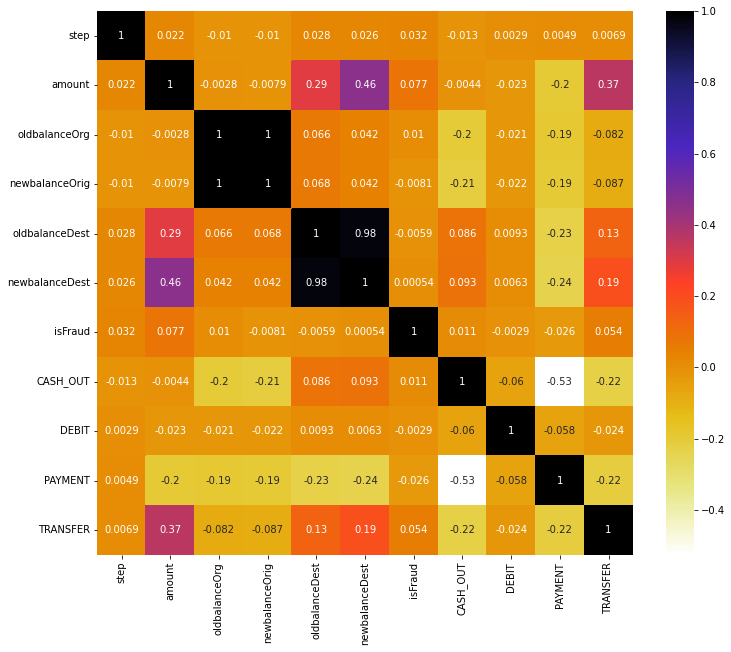

In [66]:
import seaborn as sns
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = encoded_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [67]:
encoded_df

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0.0,0.0,1.0,0.0
1,1,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0.0,0.0,1.0,0.0
2,1,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0.0,0.0,0.0,1.0
3,1,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,1.0,0.0,0.0,0.0
4,1,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,1.0,0.0,0.0,0.0
6362616,743,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0.0,0.0,0.0,1.0
6362617,743,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,1.0,0.0,0.0,0.0
6362618,743,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0.0,0.0,0.0,1.0


In [68]:
encoded_df.drop(encoded_df.columns[[2, 3, 4, 5, 6, 7]], axis=1, inplace=True)

In [69]:
encoded_df

,step,amount,isFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,9839.64,0,0.0,0.0,1.0,0.0
1,1,1864.28,0,0.0,0.0,1.0,0.0
2,1,181.00,1,0.0,0.0,0.0,1.0
3,1,181.00,1,1.0,0.0,0.0,0.0
4,1,11668.14,0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
6362615,743,339682.13,1,1.0,0.0,0.0,0.0
6362616,743,6311409.28,1,0.0,0.0,0.0,1.0
6362617,743,6311409.28,1,1.0,0.0,0.0,0.0
6362618,743,850002.52,1,0.0,0.0,0.0,1.0


In [70]:
from sklearn.preprocessing import StandardScaler
scaling = StandardScaler()
scaled_arry = scaling.fit_transform(encoded_df[['amount']])
scaled_arry

array([[-0.28155992],
       [-0.29476726],
       [-0.2975548 ],
       ...,
       [10.1539526 ],
       [ 1.1097649 ],
       [ 1.1097649 ]])

In [71]:
scaled_cat = encoded_df.drop('amount', axis=1)
scaled_cat

,step,isFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,0,0.0,0.0,1.0,0.0
1,1,0,0.0,0.0,1.0,0.0
2,1,1,0.0,0.0,0.0,1.0
3,1,1,1.0,0.0,0.0,0.0
4,1,0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...
6362615,743,1,1.0,0.0,0.0,0.0
6362616,743,1,0.0,0.0,0.0,1.0
6362617,743,1,1.0,0.0,0.0,0.0
6362618,743,1,0.0,0.0,0.0,1.0


In [72]:
encoded_amount = pd.DataFrame(scaled_arry,columns=['amount'])

In [73]:
encoded_df = pd.concat([scaled_cat,encoded_amount],axis=1)

In [74]:
encoded_df

,step,isFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER,amount
0,1,0,0.0,0.0,1.0,0.0,-0.281560
1,1,0,0.0,0.0,1.0,0.0,-0.294767
2,1,1,0.0,0.0,0.0,1.0,-0.297555
3,1,1,1.0,0.0,0.0,0.0,-0.297555
4,1,0,0.0,0.0,1.0,0.0,-0.278532
...,...,...,...,...,...,...,...
6362615,743,1,1.0,0.0,0.0,0.0,0.264665
6362616,743,1,0.0,0.0,0.0,1.0,10.153953
6362617,743,1,1.0,0.0,0.0,0.0,10.153953
6362618,743,1,0.0,0.0,0.0,1.0,1.109765


In [75]:
legit = encoded_df[encoded_df.isFraud == 0]
fraud = encoded_df[encoded_df.isFraud == 1]

In [76]:
print(legit.shape,fraud.shape)

(6354407, 7) (8213, 7)


### **Under-Sampling**

Building a sample dataset containing similar distribution of normal transactions and fraudulent transactions

Number of fraudulent transactions --> 8213

In [77]:
 legit_sample = legit.sample(n=8213)

Concatenate two DataFrames

In [78]:
new_dataset = pd.concat([legit_sample, fraud], axis=0)

In [79]:
new_dataset.head()

,step,isFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER,amount
1601142,156,0,1.0,0.0,0.0,0.0,-0.098729
2391019,201,0,0.0,0.0,0.0,1.0,1.065625
4958984,351,0,0.0,0.0,0.0,0.0,-0.233516
2312509,188,0,0.0,0.0,0.0,0.0,0.002194
4188704,305,0,0.0,0.0,0.0,0.0,-0.175592


Splitting the data into Features and Targets

In [80]:
X = new_dataset.drop(columns='isFraud', axis=1)
Y = new_dataset['isFraud']

In [81]:
print(X)
print(Y)

         step  CASH_OUT  DEBIT  PAYMENT  TRANSFER     amount
1601142   156       1.0    0.0      0.0       0.0  -0.098729
2391019   201       0.0    0.0      0.0       1.0   1.065625
4958984   351       0.0    0.0      0.0       0.0  -0.233516
2312509   188       0.0    0.0      0.0       0.0   0.002194
4188704   305       0.0    0.0      0.0       0.0  -0.175592
...       ...       ...    ...      ...       ...        ...
6362615   743       1.0    0.0      0.0       0.0   0.264665
6362616   743       0.0    0.0      0.0       1.0  10.153953
6362617   743       1.0    0.0      0.0       0.0  10.153953
6362618   743       0.0    0.0      0.0       1.0   1.109765
6362619   743       1.0    0.0      0.0       0.0   1.109765

[16426 rows x 6 columns]
1601142    0
2391019    0
4958984    0
2312509    0
4188704    0
          ..
6362615    1
6362616    1
6362617    1
6362618    1
6362619    1
Name: isFraud, Length: 16426, dtype: int64


In [82]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)

In [83]:
print(X.shape, X_train.shape, X_test.shape)

(16426, 6) (13140, 6) (3286, 6)


Model Training

Logistic Regression

In [84]:
model = LogisticRegression()

In [85]:
#training the logistic regression model with training data
model.fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

Model Evalutaion

Accuracy Score

In [86]:
# accuracy on training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

In [87]:
print('Accuracy on training data: ', training_data_accuracy)

Accuracy on training data:  0.826179604261796


In [88]:
# accuracy on test data
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)

In [89]:
print('Accuracy score on Test Data: ', test_data_accuracy)

Accuracy score on Test Data:  0.8414485696895923
